In [1]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import math
import warnings
from IPython.display import clear_output, HTML

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint
import requests

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

In [2]:
PREVIEW_REVIEW_SIZE = 1000
CHUNK_SIZE = 10000
EXTRACT_PARQUET = False
PREPROCESS_IMAGES = False
EXTRACT_CNN_FEATURES = False
REQUEST_YELP = False

# SAMPLING
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

YELP_CLIENT_ID = '9YdHyRH4uodO_PVLWQisUA'
YELP_API_KEY = '7n-jw4kngIfHFPULb9NXfFt0iy0RliPO1ksKqJOykdPVbWU6uSipZld_LPm0CKuto3nmmMLZ6U8vvlrG7J8Lbbe_NTbgpVD4MZXmLBozFALZPaKeoZRemAg1Ph9JZXYx'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)

sns.set()
pandarallel.initialize(progress_bar=True, verbose=False)

# Trick for jupyter lab with pyLdaVis
css_str = """<style> 
    .jp-Button path { fill: var(--jp-inverse-layout-color3);}
    .lm-TabBar-tabIcon path { fill: var(--jp-inverse-layout-color3);}
    .jp-icon-warn0 path {fill: var(--jp-inverse-layout-color3);}
    .bp3-button-text path {    fill: var(--jp-inverse-layout-color3);}
    .jp-icon-brand0 path { fill: var(--jp-inverse-layout-color3);}
    text.terms { fill: var(--jp-inverse-layout-color3);}
</style>"""  
display(HTML(css_str))

# Extractions des sujets des reviews

In [3]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Nom du fichier', 'Taille du fichier']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.sample(1).iloc[0])

    return df   

def printHtmlH(text, level):
    display(HTML(f'<h{level} style="text-decoration:underline">{text}</h{level}'))

def printHtmlList(items_list, tag='ul'):
    html_list = f'<{tag}>'
    for item in items_list:
        html_list = html_list + f'<li>{item}</li>'
    html_list = html_list + f'</{tag}>'
    display(HTML(html_list))

## Prévisualiastions des datasets

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
#print('')
#print(tabulate([[k,v] for k,v in files.items()]))

Nom du fichier                       Taille du fichier
-----------------------------------  -------------------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb


In [5]:
preview_dfs = {}
for name in files:
    printHtmlH(f'Prévualisation du DataSet: "{name}"', '4')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

business_id                          name  \
732  ELKgARoj5UNjQXUkX8T8KQ                    Laundromat   
919  FdA6P5CW6_8okbKwk0tpeA     Reineke Decorating Center   
43   Kq51_lGAgAigqmENITTr-A            Bala Better Health   
222  8c0r7olQSYGcws0bTd3ikw                 Zesty Tsunami   
260  pIUQz-zGw-Nu_Pu-qoTGuw  Western Endocrine Associates   

                             address             city state postal_code  \
732                   2509 E 65th St     Indianapolis    IN       46220   
919               8121 Manchester Rd      Saint Louis    MO       63144   
43             2 Bala Plz, Ste PL-11      Bala Cynwyd    PA       19004   
222                   6614 Osteen Rd  New Port Richey    FL       34653   
260  6365 E Tanque Verde Rd, Ste 200           Tucson    AZ       85715   

      latitude   longitude  stars  review_count  is_open  \
732  39.874886  -86.119551    4.5            78        1   
919  38.612049  -90.337262    4.0             8        1   
43   40.006870  -75.217262    4.0            13        1   
222  28.250218  -82.682441    4.0             5        0   
260  32.245777 -110.857387    2.0            15        1   

                                            attributes  \
732  {'RestaurantsPriceRange2': '2', 'BusinessParki...   
919  {'BusinessAcceptsCreditCards': 'True', 'Busine...   
43   {'WiFi': 'u'free'', 'BusinessAcceptsBitcoin': ...   
222  {'RestaurantsReservations': 'False', 'Restaura...   
260                                               None   

                                            categories  \
732  Local Services, Laundry Services, Dry Cleaning...   
919  Home Decor, Paint Stores, Home & Garden, Shopping   
43   Health & Medical, Beauty & Spas, Laser Hair Re...   
222  Hawaiian, Food, Food Trucks, Street Vendors, R...   
260  Health & Medical, Doctors, Endocrinologists, I...   

                                                 hours  
732  {'Monday': '0:0-0:0', 'Tuesday': '7:0-21:30', ...  
919  {'Monday': '6:30-17:30', 'Tuesday': '6:30-17:3...  
43        {'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0'}  
222  {'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...  
260  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...

business_id                                Unf5cncllS4V_CKQmp2V9Q
name                                           Advance Auto Parts
address                                       13015 Seminole Blvd
city                                                        Largo
state                                                          FL
postal_code                                                 33778
latitude                                                27.891748
longitude                                              -82.786474
stars                                                         4.0
review_count                                                    9
is_open                                                         1
attributes      {'BusinessAcceptsCreditCards': 'True', 'Restau...
categories                      Auto Parts & Supplies, Automotive
hours           {'Monday': '7:30-21:0', 'Tuesday': '7:30-21:0'...
Name: 899, dtype: object

business_id                                               date
27   --lqIzK-ZVTtgwiQM63XgQ  2011-07-29 16:37:02, 2011-10-24 16:00:29, 2012...
267  -70gmot_C918Aw_1_l5yeg  2013-06-13 13:31:51, 2013-07-15 21:51:06, 2013...
73   -1-8eimDEnS9fezJNZkQkQ           2020-05-23 14:57:09, 2020-05-24 07:42:44
919  -RckAAIJ-_KH0AzqrekYuw  2018-04-06 18:30:26, 2018-04-14 16:17:47, 2018...
614  -HbvKXJ7yMsOefB6SHd3KA  2010-04-13 21:34:21, 2010-04-15 21:16:00, 2010...

business_id                               -A2OLubXDsMRPNN7LqohPA
date           2014-04-03 22:50:35, 2014-05-22 17:37:34, 2014...
Name: 373, dtype: object

review_id                 user_id             business_id  \
418  lAjAKzVgkUHcq1aLHzDBDA  d9enV9vczP57YFObuHTn_g  KIph7iH97vnDrgcdaqEMFQ   
920  EWmkTBDTjOQpckZtyMudIQ  IZ6HdSnPbJqvvG4S6GBaWg  oqP1oQEycpp4J6u5YebRoQ   
634  MA5iblOZ4FWIQ_B3UBKKMA  HYvQKlH_LaPG8-FuJqTw1w  FHNIvNgh3fS7VZQq2Y3dsA   
631  ZSDnT-TxnDOXfed43-2Ryw  4SQ-coMQkDT63eYyvksYXg  WRMlifrYLjRY8q5YUUbfZA   
610  lQF3kV6JazQ8chYr4ZKG4w  LXvn-Wl2Sjzvl_7TxK-x6g  gGyqnAlpFrka_qzpO7j4lQ   

     stars  useful  funny  cool  \
418      2       0      1     0   
920      1       0      0     0   
634      4       0      0     0   
631      5       9      3     3   
610      5       0      0     0   

                                                  text                date  
418  I can walk here and won't go back even if they... 2013-03-19 03:14:09  
920  After numerous visits here, we really wanted t... 2018-07-26 14:21:11  
634  Second visit even better than the first!!  Lov... 2017-01-27 21:37:20  
631  Went here for dinner on opening day and was SO... 2016-02-24 00:07:09  
610  I love going to Phillies games sooo much and t... 2008-12-03 16:13:28

review_id                                 6I8MMW6gsBWSWNXFf3MUdg
user_id                                   kQWfYLrDdaIJ4KBV4BrrIQ
business_id                               5MIiTuQP0fkAz43aQEBrWA
stars                                                          5
useful                                                         3
funny                                                          0
cool                                                           4
text           Let me preface by saying that I have been gett...
date                                         2011-04-23 20:36:02
Name: 242, dtype: object

user_id             business_id  \
506  X_Tad4Ahz8USsonLu-YfHw  muxda1cSVtplETqTfYVgZA   
285  0jG8jIMK_61QovBdCiA_2Q  9A5Gw0At6so0x-vWM0_JZw   
181  oYn4yU4hI8w9vMQkR9bx1w  BkVw-eo0TutX8SmLpDzfMA   
177  5p2XL4dlvyh8jYJDA6HfLA  jRpK8oG_8QKaPGaaKiCyng   
182  0olssiUH8NXpfOb5si5Jxw  2LfH-mKHRnMZ5qx0gj8PXw   

                                                  text                date  \
506                                   Great hamburger! 2011-10-01 01:32:08   
285                                     My favorite!!! 2017-03-26 14:53:47   
181  Just hangin and shaking hands with Sister Haze... 2013-08-29 02:03:42   
177                                   Love this place! 2017-09-20 21:51:12   
182  Great place for shoes awesome prices. Great pr... 2013-02-07 18:41:13   

     compliment_count  
506                 0  
285                 0  
181                 0  
177                 0  
182                 0

user_id             BWCQF9mmaK9Vzer6rgSU7g
business_id         XsW_8i0G0pvkw9q2EUsqCA
text                           Cute inside
date                   2012-11-03 02:37:02
compliment_count                         0
Name: 933, dtype: object

user_id     name  review_count        yelping_since  \
941  LT8St8zfRqI-XUKtjZFfxA     Gwen            44  2007-07-09 20:16:53   
588  KtUS6HMhgIPHXuwwkwReEw      Kim           405  2007-12-18 19:50:48   
485  TCauYZf5swof7iCPsBUmsg   Ferdie             3  2010-09-01 00:21:25   
531  7eeANPaL34dTeUyqy9cIYw  Monique           101  2011-03-22 05:39:02   
907  4CbwHg39p4eLpCe3HfGZcQ      Ian           203  2010-01-07 19:50:44   

     useful  funny  cool                               elite  \
941     119     69    90                      2007,2008,2009   
588    5886   5640  5230  2008,2009,2010,2011,2012,2013,2014   
485       4      1     0                                       
531     375    230   301                           2012,2013   
907     363    105   111            2010,2011,2012,2013,2014   

                                               friends  fans  ...  \
941  y8aWXOimQ9ZgUgZ6q--nCQ, EHEjlSYNhtn-xHWWQz4Gyg...     6  ...   
588  hZbJoF2v9N1l5QJQ86d_Cw, f6KLPWwcaufzhjWy1mVi2w...   254  ...   
485  h1ItHyxG4BPd0AxlkzkO0A, I-hym_8QoUMLI13w7mHaJg...     2  ...   
531  HuN3E2lP3JQbnyeDAn1p2A, TZelLnaGbHgaG7LBI6rfgg...    40  ...   
907  5OFVq6LA4g33FbzQtutl_w, juNenpxI4o6-9IXtgHoFag...    17  ...   

     compliment_more  compliment_profile  compliment_cute  compliment_list  \
941                1                   1                0                0   
588               87                 144              333               37   
485                0                   0                0                0   
531                7                   6               11                1   
907                2                   2                0                1   

     compliment_note  compliment_plain  compliment_cool  compliment_funny  \
941                5                 3                8                 8   
588              319              1359             1394              1394   
485                0                 1                0                 0   
531               12                30               51                51   
907               15                35               19                19   

     compliment_writer  compliment_photos  
941                  0                  0  
588                562                383  
485                  0                  0  
531                 65                 13  
907                 16                  3  

[5 rows x 22 columns]

user_id                                          M628_58sbDGaViQrxsPuqA
name                                                            Melissa
review_count                                                        224
yelping_since                                       2009-08-28 17:39:48
useful                                                              337
funny                                                               157
cool                                                                124
elite                                     2010,2011,2012,2013,2014,2015
friends               MGPQVLsODMm9ZtYQW-g_OA, 30Y8yt-Xyb1c5SasVTpEZA...
fans                                                                 12
average_stars                                                      3.48
compliment_hot                                                       16
compliment_more                                                       6
compliment_profile                                              

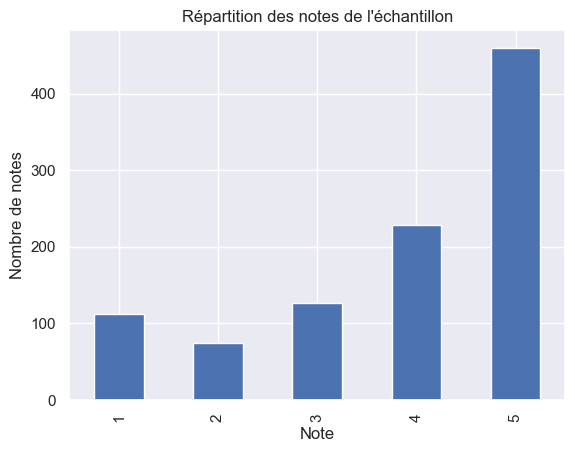

23% des reviews ont au maximum 2 étoiles


In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar(xlabel="Note", ylabel="Nombre de notes", title="Répartition des notes de l'échantillon")
plt.show()

bad_stars = 2
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > bad_stars
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]
print(f'{sampling_coef_bad*100:.0f}% des reviews ont au maximum {bad_stars} étoiles')

In [7]:
printHtmlH("Apperçu des catégories", "3")
printHtmlList(list(preview_dfs['business']['categories'].unique()[0:20]) + ["etc..."], "ol")

In [8]:
printHtmlH("Apperçu de quelques reviews par note", "3")
review = preview_dfs['review']
for star in range(1,6):
    printHtmlH(f'Note = {star}', "4")
    display(HTML('<hr>'))
    for index in review[review['stars']==star].sample(2, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        quote = HTML(f'<div style="border-left: 4px solid yellow; padding-left:10px; margin-bottom:20px;">{text}</div>')
        display(quote)

## Extraction d'un échantillons de reviews

In [9]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])

In [10]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [11]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

Caractéristique de l'extraction
- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité: 1000 reviews par note
- Stockage dans des fichiers parquets

In [12]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [13]:
def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list    
    
def display_word_cloud(reviews, no_below = 4, no_above = 0.1, max_words_in_cloud=50, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')

    # Join text and display wordcloud
    sample_text = ' '.join(sample.str.join(' ').values)
    wordcloud = WordCloud(background_color = 'white', max_words = max_words_in_cloud).generate(sample_text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();
    print('')

## Nuages de mots par note

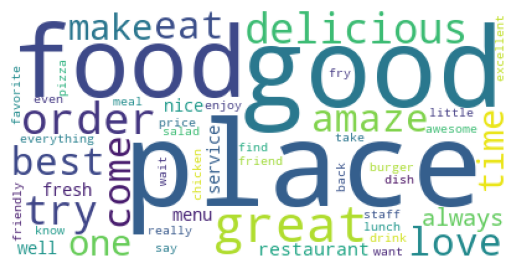

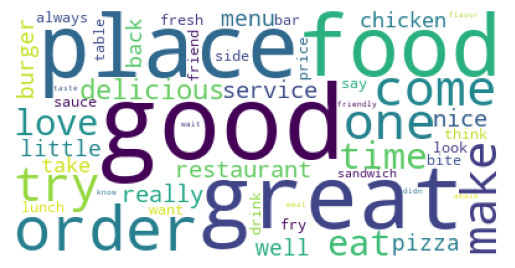

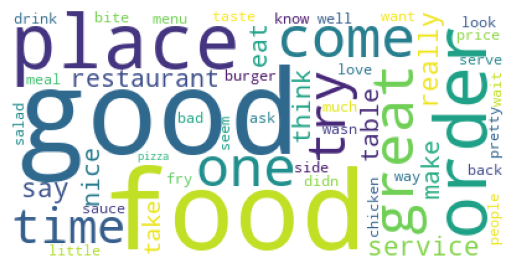

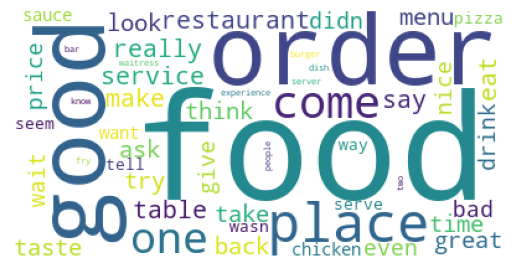

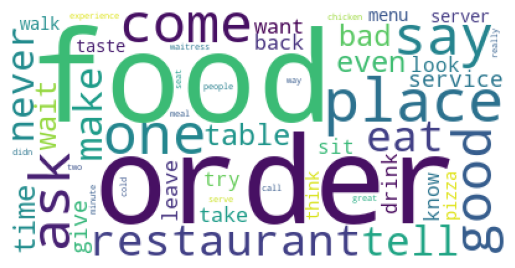

In [14]:
for stars in range(5,0,-1):
    printHtmlH(f'Note = {stars}', "3")
    display_word_cloud(reviews=get_reviews(stars=stars),
                       no_below=2,
                       no_above= 0.1, 
                       max_words_in_cloud=50)

## Recherche des sujets d'insatisfactions

### Sac de mots (TF-IDF)

In [15]:
def tf_idf(reviews, min_df = 4, max_df = 100, ngram_range=(1,2), verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    return values, vectorizer.get_feature_names_out()

In [16]:
print(f'Vectorisation pour les reviews comportant maximum {bad_stars} étoiles')
reviews = get_reviews(max_stars=bad_stars)
values, features_names = tf_idf(reviews=reviews,
                                min_df=10,
                                max_df=0.1,
                                ngram_range=(1,2),
                                verbose=1)

Vectorisation pour les reviews comportant maximum 2 étoiles
Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


100  1st  2nd  able  absolute  absolutely  accept  accommodate  \
0  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
1  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
2  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
3  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
4  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   

   acknowledge  across  ...  yelp       yes  yesterday  yet  york  young  \
0          0.0     0.0  ...   0.0  0.231769        0.0  0.0   0.0    0.0   
1          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
2          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
3          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
4          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   

   yuck  yummy      zero  zero star  
0   0.0    0.0  0.000000        0.0  
1   0.0    0.0  0.000000        0.0  
2   0.0    0.0  0.176228        0.0  
3   0.0    0.0  0.000000        0.0  
4   0.0    0.0  0.000000        0.0  

[5 rows x 1901 columns]

+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.2965           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | anyone: 0.2395           |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | attention: 0.2499        |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | cash: 0.2758             |
|                                                                           

### LDA (Librairie Sklearn)

In [17]:
def get_topics(reviews: pd.DataFrame, min_df = 4, max_df = 10, n_topics = 10, alpha = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)
    
    if verbose > 1: print('  - Vectorisation (tf-idf)')
    values, features_names = tf_idf(reviews=reviews, min_df=min_df, max_df=max_df, ngram_range=ngram_range, verbose = 0)

    # Topics from LDA or MDF
    if verbose > 1: print('  - Modélisation LDA')
    model = LatentDirichletAllocation(n_components=n_topics,
                                      max_iter=10,
                                      doc_topic_prior=alpha,
                                      learning_method='online', 
                                      learning_offset=10,
                                      random_state=0,
                                      n_jobs=-1)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        features = [features_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)

    return topics

In [18]:
params = {
    'max_stars': bad_stars,
    'min_df': 2,
    'max_df': 0.1,
    'n_topics': 3,
    'alpha': 0.5,
    'n_top_words': 5,
    'ngram_range': (1,1)
}

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.1
n_topics     3
alpha        0.5
n_top_words  5
ngram_range  (1, 1)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ---------------------------------------
         0  pizza, waitress, burger, sauce, bar
         1  mahi, vista, isla, cashew, angelo
         2  donut, fancy, environment, refer, bueno


In [19]:
params['alpha'] = 0.8
params['max_df'] = 0.2
params['ngram_range'] = (3,3)

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.2
n_topics     3
alpha        0.8
n_top_words  5
ngram_range  (3, 3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ----------------------------------------------------------------------------------------------
         0  would not recommend, waste time money, wait another minute, not recommend place, give one star
         1  not very good, want like place, food good service, nothing write home, give two star
         2  take minute get, not worth wait, service very slow, food nothing special, not worth price


### LDA (Librairie Gensim)

In [20]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')

    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=False, verbose=False)
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=max_stars)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, alpha = 10, num_topics = 10):
    print(f'  - LDA pour {num_topics} topics')
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

In [21]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[2,3], no_below=2, no_above=0.2)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=3)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 3 topics
+------------+--------------------------+
|   Topic n° | mots clés                |
+============+==========================+
|          1 | 0.004*"taste like"       |
|            | 0.004*"come back"        |
|            | 0.003*"win back"         |
|            | 0.003*"food not"         |
|            | 0.002*"not good"         |
|            | 0.002*"mac cheese"       |
|            | 0.002*"wait staff"       |
|            | 0.001*"felt like"        |
|            | 0.001*"very good"        |
|            | 0.001*"place not"        |
+------------+--------------------------+
|          2 | 0.002*"not worth"        |
|            | 0.002*"look like"        |
|            | 0.002*"next time"        |
|            | 0.002*"much good"        |
|            | 0.002*"very disappoint"  |
|            | 0.002*"not sure"         |
|            | 0.002*"first time"       |
|            | 0.002*"come back"        |


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.159450 -0.011734       1        1  33.735093
0      0.090075 -0.129716       2        1  33.383980
1      0.069375  0.141450       3        1  32.880927, topic_info=             Term       Freq       Total Category  logprob  loglift
97     taste like  96.000000   96.000000  Default  30.0000  30.0000
71       get food  61.000000   61.000000  Default  29.0000  29.0000
2046   last night  35.000000   35.000000  Default  28.0000  28.0000
975   wait minute  49.000000   49.000000  Default  27.0000  27.0000
169      food not  52.000000   52.000000  Default  26.0000  26.0000
...           ...        ...         ...      ...      ...      ...
63      come back  28.714865  121.531101   Topic3  -6.4109  -0.3305
2184     one star  18.620230   30.926835   Topic3  -6.8441   0.6049
2826  even though  19.725269   47.432808   Topic3  -6.7864   0.2349
1285    food come  18.671544   36.723787   Topic3  -6.8413   0.4359
112     didn even  18.811760   43.610442   Topic3  -6.8339   0.2715

[219 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
2886      3  0.948824        across street
1546      1  0.916757        almost minute
2201      1  0.958333             ask move
1039      2  0.917524         average food
1284      1  0.866426       bad experience
...     ...       ...                  ...
1037      2  0.118084            would not
1037      3  0.059042            would not
2868      1  0.899299  would not recommend
2868      2  0.074942  would not recommend
2125      1  0.971013            zero star

[337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [22]:
texts, dictionary, corpus = prepare_data(max_stars=1, n_grams=[3], no_below=2, no_above=0.1)
model = modelize(dictionary=dictionary, corpus=corpus, alpha=20, num_topics=3)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 3 topics
+------------+-----------------------------+
|   Topic n° | mots clés                   |
+============+=============================+
|          1 | 0.009*"never come back"     |
|            | 0.008*"waste time money"    |
|            | 0.005*"could give zero"     |
|            | 0.004*"would not recommend" |
|            | 0.004*"get money back"      |
|            | 0.004*"take drink order"    |
|            | 0.004*"buy one get"         |
|            | 0.004*"not come back"       |
|            | 0.003*"take minute get"     |
|            | 0.003*"get order right"     |
+------------+-----------------------------+
|          2 | 0.005*"want like place"     |
|            | 0.005*"take minute get"     |
|            | 0.004*"speak manager tell"  |
|            | 0.004*"say didn know"       |
|            | 0.004*"never come back"     |
|            | 0.004*"make eye contact"    |
|            | 0.004*"wo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.004563 -0.019382       1        1  33.371427
1     -0.021508  0.006242       2        1  33.331019
2      0.016946  0.013141       3        1  33.297554, topic_info=                      Term      Freq     Total Category  logprob  loglift
192     speak manager tell  4.000000  4.000000  Default  30.0000  30.0000
129        come take order  6.000000  6.000000  Default  29.0000  29.0000
69        waste time money  9.000000  9.000000  Default  28.0000  28.0000
150         last time come  2.000000  2.000000  Default  27.0000  27.0000
154  lack customer service  2.000000  2.000000  Default  26.0000  26.0000
..                     ...       ...       ...      ...      ...      ...
67     wait another minute  1.846004  5.672608   Topic3  -5.8937  -0.0229
69        waste time money  2.124766  9.931349   Topic3  -5.7530  -0.4423
214          give one star  1.762124  4.963941   Topic3  -5.9402   0.0640
330        take minute get  1.832554  7.091232   Topic3  -5.9010  -0.2535
236    would not recommend  1.786240  7.092200   Topic3  -5.9266  -0.2792

[199 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
371       2  0.470191  another minute drink
739       1  0.469911    another minute get
182       1  0.176287     ask speak manager
182       2  0.352573     ask speak manager
182       3  0.352573     ask speak manager
...     ...       ...                   ...
236       3  0.282000   would not recommend
539       2  0.470171      would waste time
195       1  0.402883       zero star would
195       2  0.402883       zero star would
195       3  0.201442       zero star would

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# Classifications des images

## Prévisualisation du dataset

In [23]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

photo_id             business_id  \
87869   KqmrrPhsUWJjDQap8yCDGA  8pqdJjefYq-a9IBSJJmKwA   
134029  msGQFmPSccijvcXaxWxFew  l8gAoQqqVfphPe9jmIJZ3g   
114726  Bq5gX0FHDTKXDr0cpVDQYQ  wLV_IZfy6nrNbplZ5sHJKQ   
186664  F7CaXusJa3nL4RmASqjPDQ  QboMIy08NLnBbLXEsmnDHg   
22155   FKFa1agaXVS8umHiK3FChw  Djg4suxDMaSwmR_RkrxYBw   

                                 caption   label  
87869   Upstairs bar area - so beautiful  inside  
134029                                      food  
114726                                      food  
186664                                      food  
22155                                       food

In [24]:
df_photos.shape

(200100, 4)

In [25]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

L'échantillon contient 500 images


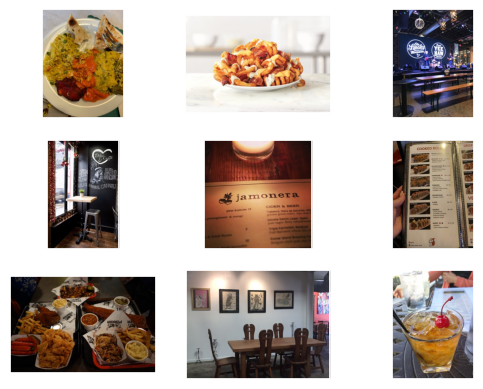

In [26]:
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'
    
photo_ids = {}
df_photos_sampling = pd.DataFrame()
for label in df_photos.label.unique():
    photo_ids = list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])
    df_label = pd.DataFrame({
        'photo_id': photo_ids,
        'label': np.full(len(photo_ids), label),
        'width': np.zeros(len(photo_ids)), 
        'height': np.zeros(len(photo_ids)), 
        'mode': np.full(len(photo_ids), '')
    })
    df_photos_sampling = pd.concat([df_photos_sampling, df_label], ignore_index=True)

label_encoder = LabelEncoder()
df_photos_sampling['label_num'] = label_encoder.fit_transform(df_photos_sampling['label'])

print(f'L\'échantillon contient {df_photos_sampling.shape[0]} images')

sample_ids = list(df_photos_sampling.sample(9, random_state=1)['photo_id'])
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = matplotlib.image.imread(get_original_photo_path(sample_ids[i]))
    plt.imshow(image)
    plt.grid(linewidth=0)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

In [27]:
def fill_infos(df):
    for index in df.index:
        #print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.sample(5)

photo_id    label  width  height mode  label_num
440  3UOTs5KNs6qxW3gXwBedNg     menu  533.0   400.0  RGB          3
138  oRvMWKsspQ4l2N3s46Bg5w  outside  404.0   400.0  RGB          4
205  hKuMtqcDG93E_fwip9e12Q    drink  300.0   400.0  RGB          0
303  qub7UPWtQnOBWtFcHdqdig     food  600.0   399.0  RGB          1
454  BTYEqUgrQ57vhnWT95GkfQ     menu  300.0   400.0  RGB          3

In [28]:
df_photos_sampling.describe()

width      height  label_num
count  500.000000  500.000000  500.00000
mean   438.882000  389.688000    2.00000
std    131.985303   32.814085    1.41563
min    131.000000   69.000000    0.00000
25%    300.000000  400.000000    1.00000
50%    408.000000  400.000000    2.00000
75%    543.750000  400.000000    3.00000
max    600.000000  400.000000    4.00000

In [29]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Clustering par descripteurs SIFT

In [30]:
df_sift = df_photos_sampling.copy()

### Pretraitement des images

In [31]:
def preprocess_images_sift(df):
    for index in df.index:
        #print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_sift(photo_id)

def preprocess_image_sift(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        printHtmlH('Image et son histogramme avant traitement', '4')
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img, work_part='sift')

    if display_evo:
        printHtmlH('Image et son histogramme après traitement', '4')
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
    # Apply gaussian blur
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img, work_part):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + work_part + '/' + filename
    img.save(new_path)

    return new_path

#### Exemple de pre-traitement

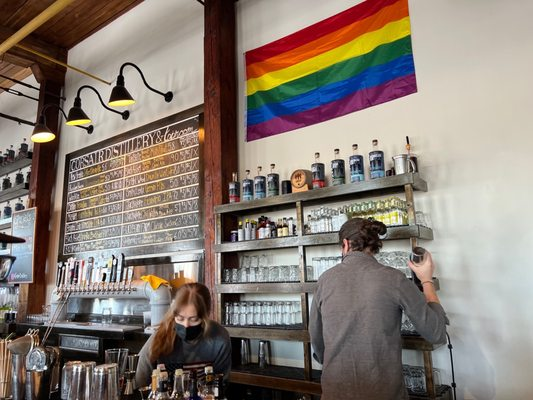

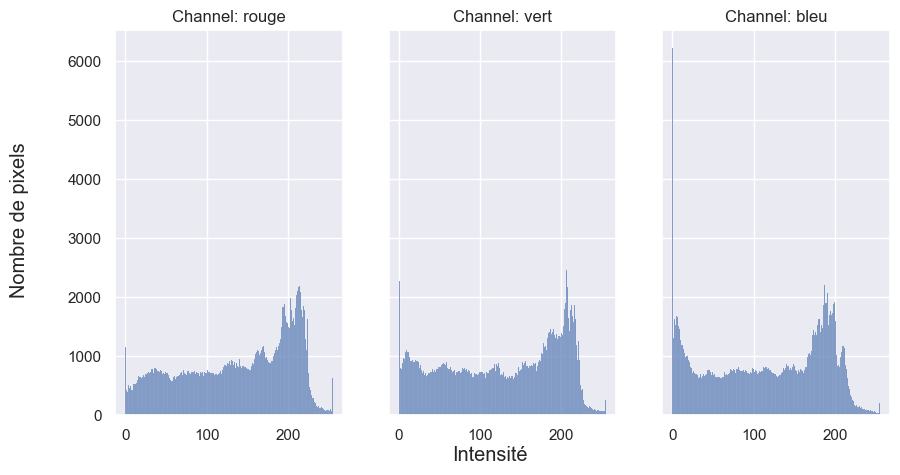

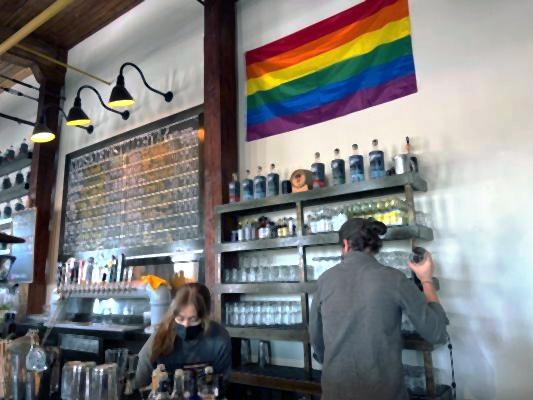

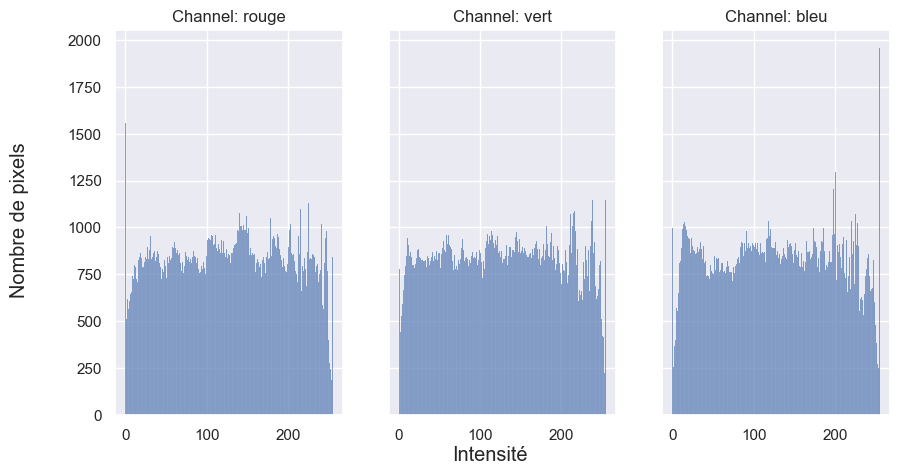

In [32]:
photo_id_sample = df_sift.sample(1, random_state=0)['photo_id'].iloc[0]
file = preprocess_image_sift(photo_id_sample,display_evo=True)

In [33]:
if PREPROCESS_IMAGES:
    preprocess_images_sift(df=df_sift)

### Creation des descripteurs

In [34]:
def get_descripteurs(photo_id, max_desc=500, work_dir = WORK_PHOTOS_DIR, plot = False, print_desc = False):
    import cv2
    sift = cv2.xfeatures2d.SIFT_create(max_desc)
    image = cv2.imread(work_dir + 'sift/' + photo_id + '.jpg')
    kp, desc = sift.detectAndCompute(image, None)

    if plot:
        img=cv2.drawKeypoints(image,kp,image)
        plt.imshow(img)
        plt.grid(linewidth=0)
        plt.show()

    if print_desc:
        print("Descripteurs : ", desc.shape)
        print()
        print(desc)
    
    return desc    

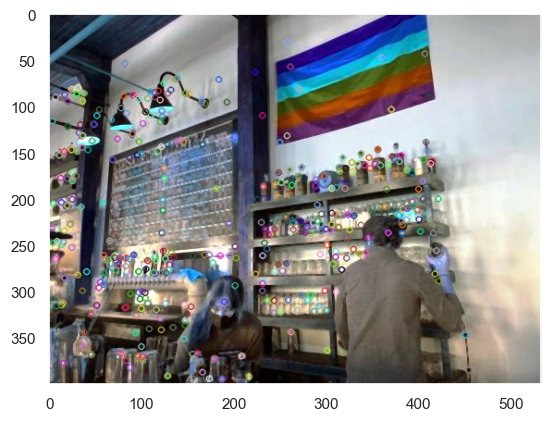

Descripteurs :  (501, 128)

[[ 0.  0.  0. ...  1. 18. 18.]
 [13. 14.  8. ... 24.  0.  1.]
 [24.  0.  0. ...  2.  5. 25.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [ 0.  0.  0. ...  0.  2. 13.]
 [ 0.  0. 10. ...  0.  0. 12.]]


In [35]:
printHtmlH('Exemple de descripteur', '4')
desc = get_descripteurs(photo_id=photo_id_sample, plot=True, print_desc=True)

In [36]:
pandarallel.initialize(progress_bar=True, verbose=False)
descripteurs = df_sift['photo_id'].parallel_apply(get_descripteurs, args=(500,))
df_sift['desc'] = descripteurs
display(df_sift.sample(3))
num_img_desc = df_sift['desc'][0].shape[0]

photo_id   label  width  height mode  label_num  \
49   FhduSWA4X_-15h3HONMLHA  inside  303.0   400.0  RGB          2   
361  WmduD0Rgc3f9NMhvAMWZqg    food  600.0   275.0  RGB          1   
352  4MFK2vcjjAQyOpHYmc2JVQ    food  400.0   400.0  RGB          1   

                                                  desc  
49   [[48.0, 25.0, 5.0, 3.0, 8.0, 45.0, 21.0, 9.0, ...  
361  [[74.0, 28.0, 1.0, 3.0, 13.0, 2.0, 1.0, 2.0, 1...  
352  [[10.0, 13.0, 12.0, 53.0, 45.0, 3.0, 1.0, 1.0,...

### Clustering des descripteurs

Principe:
- Il s'agit de regrouper tous les descripteurs en clusters
- Les clusters serviront ensuite à classifier les images par degré d'appartenance à chaque cluster

In [37]:
all_descripteurs = np.concatenate(df_sift['desc'].values, axis=0)
n_clusters = math.floor(math.sqrt(len(all_descripteurs)))
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=0, n_init="auto").fit(all_descripteurs)
print(f'Il y a {n_clusters} clusteurs pour un total de {len(all_descripteurs)} descripteurs')

Il y a 494 clusteurs pour un total de 244742 descripteurs


### Creations des features des images

Principes:

- On attribut chacun des descripeurs de l'image à un des clusters de descripteur
- Pour chacun des clusteurs on compte combien l'image contient de descripteur de ce clusteur
- On peut le visualiser en forme d'histogramme et utiliser celui comme features de l'image

In [38]:
def features_sift(descripteurs, kmeans: MiniBatchKMeans):
    import numpy as np
    desc_clusters = kmeans.predict(descripteurs)
    return np.histogram(desc_clusters, bins=kmeans.n_clusters, range=(0, kmeans.n_clusters))[0]

features = df_sift['desc'].parallel_apply(features_sift, args=(kmeans,))
df_sift['features'] = features
df_sift.sample(3)

photo_id    label  width  height mode  label_num  \
161  muDaDyPD6JXiFnmZxkLFpw  outside  300.0   400.0  RGB          4   
346  VLp98ySDWYXRmYlq-RPAhA     food  533.0   400.0  RGB          1   
367  HG5AMbCnb7s0kWdTbOWtxg     food  533.0   400.0  RGB          1   

                                                  desc  \
161  [[3.0, 31.0, 109.0, 49.0, 21.0, 30.0, 15.0, 4....   
346  [[18.0, 36.0, 101.0, 85.0, 32.0, 40.0, 7.0, 6....   
367  [[17.0, 11.0, 92.0, 88.0, 59.0, 48.0, 1.0, 0.0...   

                                              features  
161  [0, 0, 7, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...  
346  [1, 2, 2, 5, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...  
367  [1, 0, 1, 4, 0, 2, 0, 1, 0, 0, 0, 0, 2, 1, 2, ...

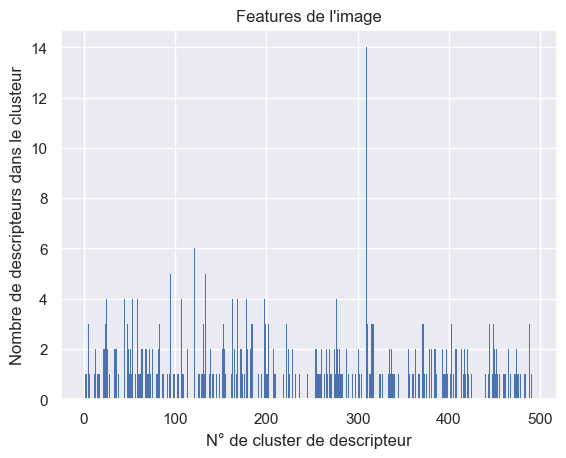

In [39]:
features_sample = df_sift['features'][0]
plt.bar(range(len(features_sample)), features_sample, linewidth=0)
plt.xlabel('N° de cluster de descripteur')
plt.ylabel('Nombre de descripteurs dans le clusteur')
plt.title('Features de l\'image')
plt.show()

### Reduction de dimension puis clustering

In [40]:
def acp(X, keep_variance = 0.99):
    print('Reduction PCA')
    pca = PCA(n_components=keep_variance, svd_solver='full')
    features_pca = pca.fit_transform(X)
    old_shape = np.array(X)[0].shape[0]
    new_shape = features_pca.shape[1]
    print(f'En concervant {keep_variance*100}% de la variance, la PCA réduit les features de {old_shape} composantes à {new_shape} composantes') 

    return features_pca

def tsne_df(df, label, features, x_tsne, y_tsne):
    print('Reduction TSNE en 2 dimensions')
    tsne = TSNE(n_components=2, perplexity=20, n_iter=15000, init='random', random_state=0)
    X_tsne = tsne.fit_transform(features)
    
    df[x_tsne] = X_tsne[:,0:1]
    df[y_tsne] = X_tsne[:,1:2]
    
    sns.scatterplot(df, x=x_tsne, y=y_tsne, hue=label)
    plt.xlabel('DIM 1')
    plt.ylabel('DIM 2')
    plt.title('Dataset réduit en 2 dimensions')
    plt.show()

def clustering(df, X, label, predict):
    print('Clustering')
    n_clusters = df[label].nunique()
    kmean_final = MiniBatchKMeans(n_clusters=5, batch_size=512, random_state=0, n_init="auto").fit(X)
    df[predict] = kmean_final.predict(X)

def graph_predict(df, x, y, label, predict, label_classes):
    print('Affichage des clusters')
    sns.scatterplot(df, x=x, y=y, hue=predict)
    plt.xlabel('DIM 1')
    plt.ylabel('DIM 2')
    plt.title('Prédiction')
    plt.show()

    labels_true = list(df[label])
    labels_pred = list(df[predict])
    
    conf_mat = confusion_matrix(labels_true, labels_pred)
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", yticklabels=label_classes)
    plt.title('Correlation des labels réels et des prédictions')
    plt.show()

    ars = adjusted_rand_score(labels_pred=labels_pred, labels_true=labels_true)
    printHtmlH(f'Adjusted rand score = {ars:.3f}', '3')

def pca_tsne_clustering(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 2 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 3: Clustering
    X_clustering = np.array([df[x_tsne], df[y_tsne]]).T
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def clustering_pca_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: Clustering
    X_clustering = list(df['features'])
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 2: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def pca_clustering_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)
    
    # Step 2: Clustering
    X_clustering = features_pca
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 494 composantes à 338 composantes
Reduction TSNE en 2 dimensions


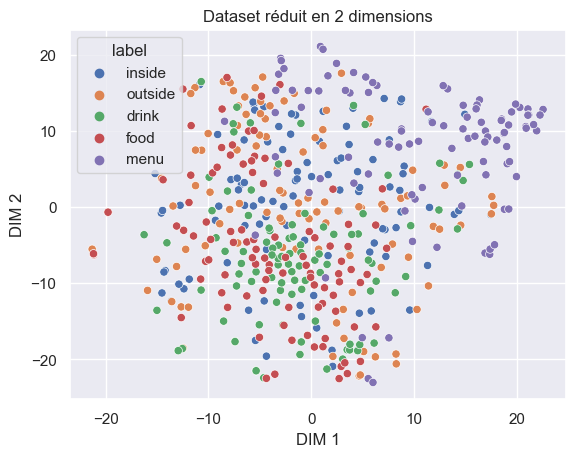

Clustering
Affichage des clusters


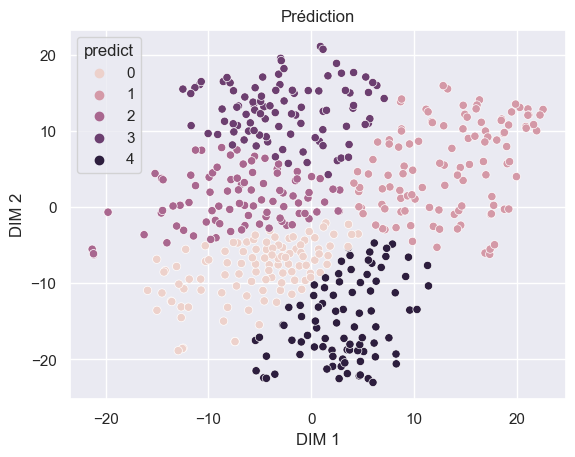

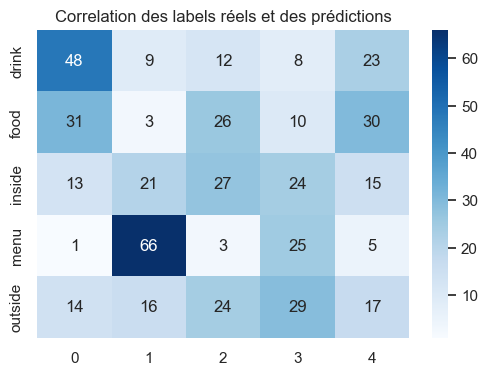

In [41]:
pca_tsne_clustering(df=df_sift, x_tsne='x_tsne', y_tsne='y_tsne', predict = 'predict')

## Clustering par CNN

In [42]:
df_cnn = df_photos_sampling.copy()

### Pretraitement des images

In [43]:
(width_max, height_max) = (int(df_cnn['width'].max()), int(df_cnn['height'].max()))

In [44]:
from PIL import Image, ImageOps

def preprocess_images_cnn(df):
    for index in df.index:
        #print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_cnn(photo_id)

def preprocess_image_cnn(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        printHtmlH('Image avant traitement', '4')
        img = display_img(original_path)
        print(f'Taille originale => Hauteur: {img.height}, Largeur: {img.width}')
    else:
        img = Image.open(original_path)

    border_width_1 = (width_max - img.width) // 2
    border_width_2 = width_max - img.width - border_width_1
    
    border_height_1 = (height_max - img.height) // 2
    border_height_2 = height_max - img.height - border_height_1
    
    img = ImageOps.expand(img,border=(border_width_1, border_height_1, border_width_2, border_height_2),fill='black')
    
    new_path = save_img(current_path=original_path, img=img, work_part='cnn')

    if display_evo:
        printHtmlH('Image après traitement', '4')
        img = display_img(new_path)
        print(f'Taille ajustée => Hauteur: {img.height}, Largeur: {img.width}')
    
    return new_path

### Exemple de pré-traitement

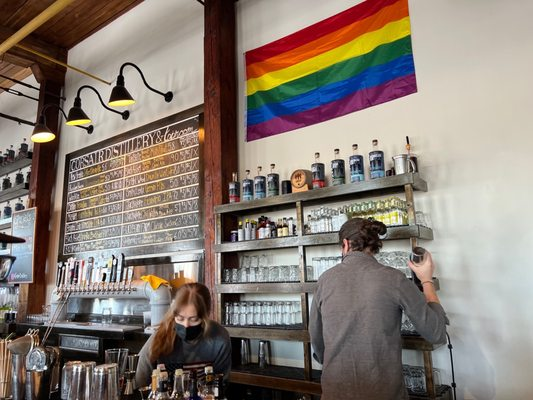

Taille originale => Hauteur: 400, Largeur: 533


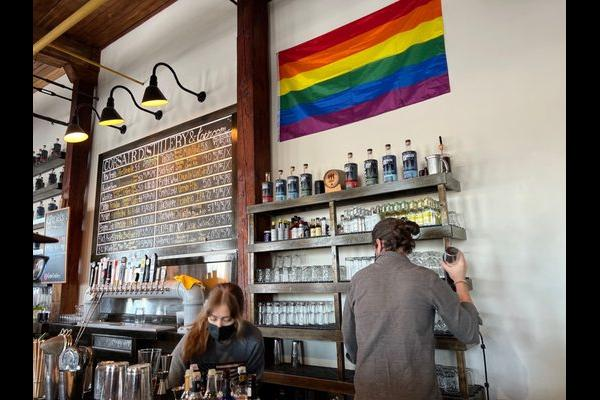

Taille ajustée => Hauteur: 400, Largeur: 600


In [45]:
file = preprocess_image_cnn(photo_id=photo_id_sample, display_evo=True)

In [46]:
if PREPROCESS_IMAGES:
    preprocess_images_cnn(df=df_cnn)

### Creation des features depuis cnn VGG16

Principe:

- On utilise VGG16 sans la partie top (sans le reseau dense)
- On extrait un vecteur 1*512 du reseau CNN pour chaque image par prédiction
- Ce vecteur représente les features de l'image: comme pour sift on réduit en 2 dimensions puis on crée des clusters des images

In [47]:
from keras.applications.vgg16 import VGG16
from keras import Input
input = Input(shape=(height_max, width_max, 3))
model = VGG16(include_top=False,input_tensor=input, weights='imagenet', pooling='max')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 150, 128)     0     

In [48]:
import keras
def features_cnn(photo_id, model, work_dir = WORK_PHOTOS_DIR):
    img_path = work_dir + 'cnn/' + photo_id + '.jpg'
    img = keras.utils.load_img(img_path)
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    
    return features[0, :]

In [49]:
df_cnn_parquet = WORK_PHOTOS_DIR + 'df_cnn.parquet'
if EXTRACT_CNN_FEATURES:
    features = df_cnn['photo_id'].apply(features_cnn, args=(model,))
    df_cnn['features'] = features
    df_cnn.to_parquet(df_cnn_parquet)
    df_cnn.sample(3)
else:
    df_cnn = pd.read_parquet(df_cnn_parquet)

In [50]:
df_cnn.sample(5)

photo_id    label  width  height mode  label_num  \
102  JziaPhFSQnNfHvFqRFjjnw  outside  320.0   400.0  RGB          4   
84   ZhPb-006uRxv6D2iuGsLNg   inside  533.0   400.0  RGB          2   
189  Ht-0vqKHAKObTBFQwqTSWQ  outside  533.0   400.0  RGB          4   
296  nPwgVv8Ue7nqpL0WwZdg0Q    drink  300.0   400.0  RGB          0   
342  VEXXIX42A2ip299Eiw4GXw     food  533.0   400.0  RGB          1   

                                              features  
102  [38.965687, 49.93799, 0.0, 16.936749, 8.714447...  
84   [8.987565, 0.0, 2.1074586, 57.541824, 53.61340...  
189  [47.591198, 65.475876, 9.290033, 8.538192, 40....  
296  [13.260925, 43.594986, 110.18538, 50.685974, 1...  
342  [74.18706, 43.220623, 49.711857, 61.6054, 51.1...

### Test 1: PCA -> TSNE -> KMEAN

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


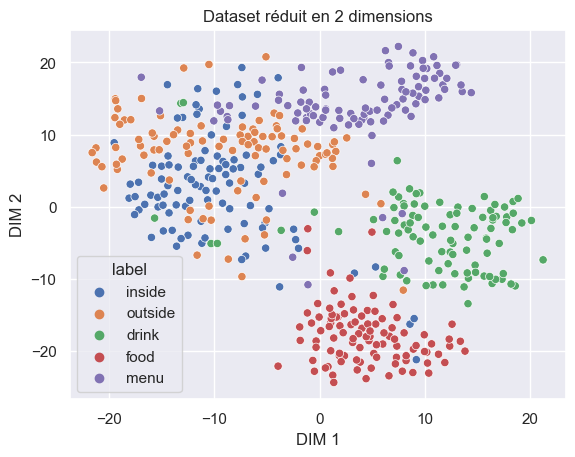

Clustering
Affichage des clusters


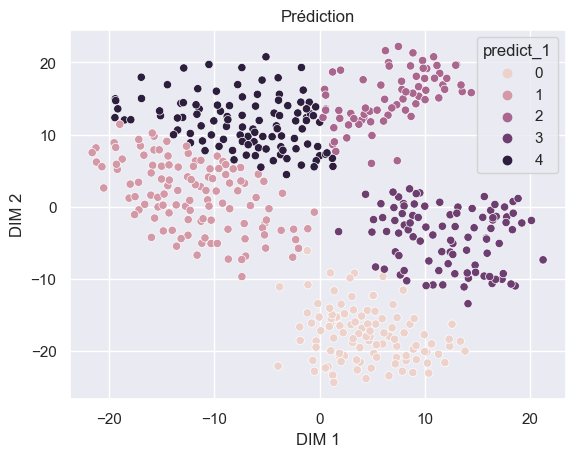

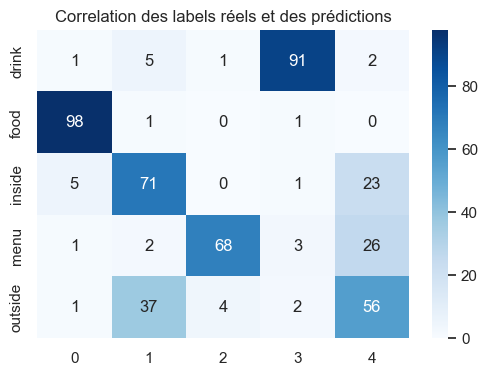

In [51]:
pca_tsne_clustering(df=df_cnn, x_tsne='x_tsne_1', y_tsne='y_tsne_1', predict='predict_1')

### Test 2: KMEAN -> PCA -> TSNE

Clustering
Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


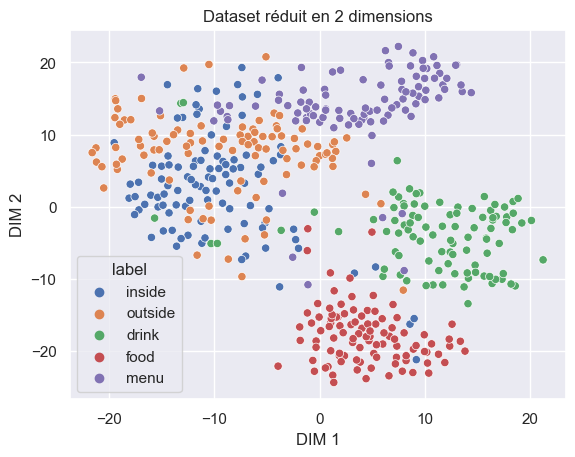

Affichage des clusters


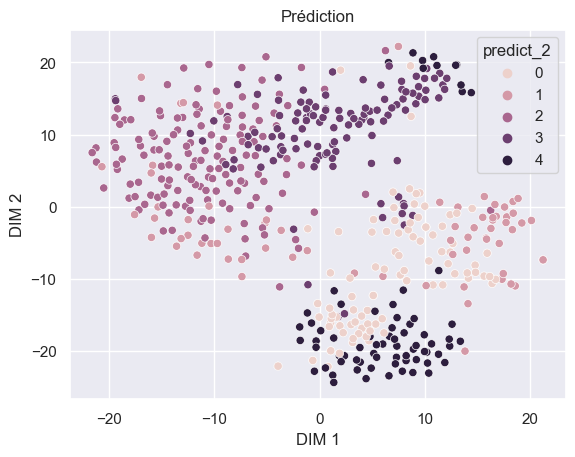

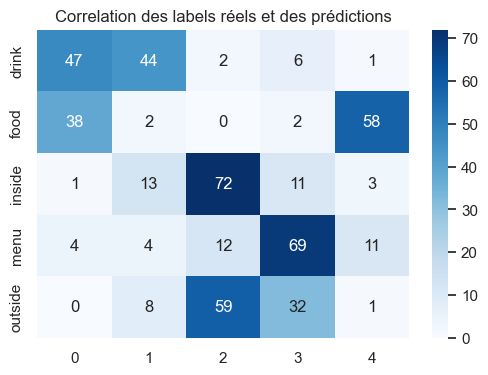

In [52]:
clustering_pca_tsne(df=df_cnn, x_tsne='x_tsne_2', y_tsne='y_tsne_2', predict='predict_2')

### Test 3: PCA (50% variance) -> KMEAN -> TSNE

Reduction PCA
En concervant 50.0% de la variance, la PCA réduit les features de 512 composantes à 21 composantes
Clustering
Reduction TSNE en 2 dimensions


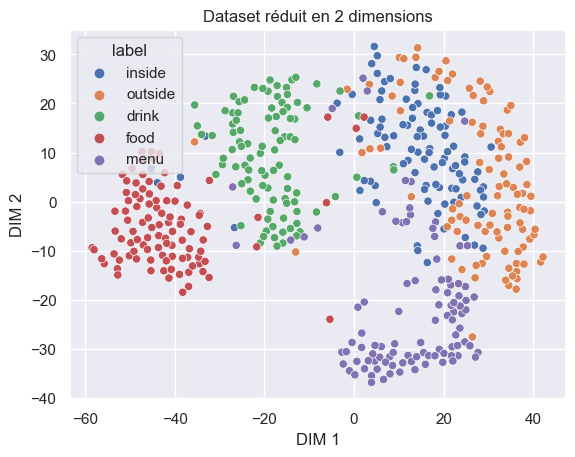

Affichage des clusters


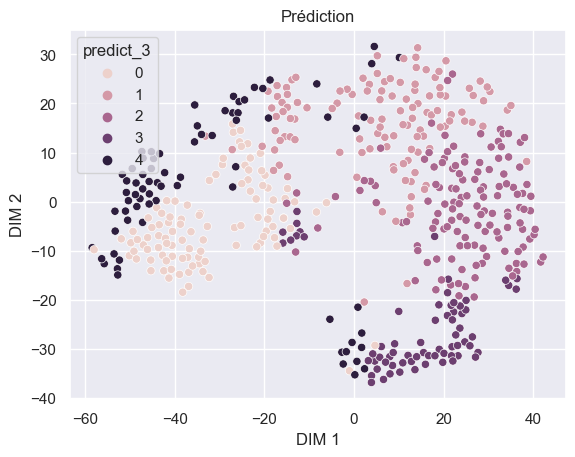

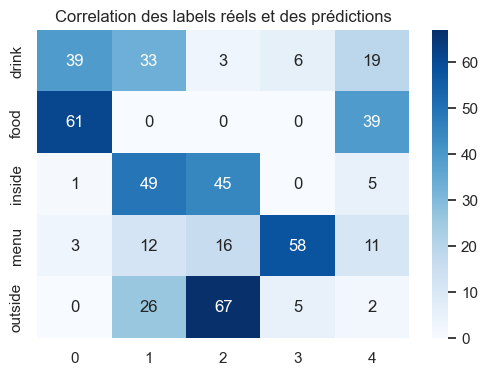

In [53]:
pca_clustering_tsne(df=df_cnn, x_tsne='x_tsne_3', y_tsne='y_tsne_3', predict='predict_3', pca_keep_variance=0.5)

# Récupération des données depuis l'API YELP

Principes:
- Faire une 1ere requete sur le point de terminaison "search" pour extraire 200 id de restaurant (une boucle avec offset sera néésssaire car le max par requete est 50)
- Faire une seconde requete en boucle sur les id des restaurants sur le point de terminaison "reviews" (3 reviews max en version gratuite sont données)
- Mettre les data dans des DataFrames puis sauver ces DataFrames en fichier parquet

In [54]:
def request_yelp(ville: str, nombre_restau: int):
    file_reviews = WORK_DATASET_DIR + 'reviews_request.parquet'
    
    if not REQUEST_YELP:
        print('Lecture depuis les fichiers de la dernière éxécution (à cause de la limite journalière de l\'API en version gratuite)')
        return pd.read_parquet(file_reviews)

    try:
        authorization = f'Bearer {YELP_API_KEY}'
        headers = {
            'Authorization': authorization,
            'accept': 'application/json'
        }
        
        # GET Business Ids
        print('search request yelp in progress')
        nombre_restau = min(nombre_restau, 200)
        limit = min(nombre_restau, 50)
        df_businesses = pd.DataFrame()
        url = 'https://api.yelp.com/v3/businesses/search'
        params={
            'location': ville,
            'categories': 'Restaurant',
            'sort_by': 'best_match',
            'limit': str(limit),
            'offset': '0'
        }
        for offset in range(0, nombre_restau, limit):
            params['offset'] = str(offset)
            response_businesses = requests.get(url=url, params=params, headers=headers)
            new_records = pd.DataFrame.from_records(response_businesses.json()['businesses'])
            df_businesses = pd.concat([df_businesses, new_records], ignore_index=True)
        
        # Get Reviews
        businesses_id = list(df_businesses['id'])
        params={
            'limit': '50', # Free account limit to 3 reviews per id...
            'offset': '0'
        }
        df_reviews = pd.DataFrame()
        for id in businesses_id:
            url = f'https://api.yelp.com/v3/businesses/{id}/reviews'
            response_reviews = requests.get(url=url, params=params, headers=headers)
            new_records = pd.DataFrame.from_records(response_reviews.json()['reviews'])
            df_reviews = pd.concat([df_reviews, new_records], ignore_index=True) 

        
        df_reviews = df_reviews.loc[:, ['text', 'rating']]
        df_reviews.to_parquet(file_reviews, engine='fastparquet')
        
        print('Succès!')
        return df_reviews
        
    except Exception as err:
        print(f'Une erreur est renvoyée: {err}')  

In [55]:
# REQUEST YELP HERE
ville = 'Paris'
nb_restau = 200
df_reviews_request = request_yelp(ville=ville, nombre_restau=nb_restau)

Lecture depuis les fichiers de la dernière éxécution (à cause de la limite journalière de l'API en version gratuite)


In [56]:
print('Extrait des reviews provenant de l\'API YELP')
display(df_reviews_request.sample(5))
print(f'Il y a {df_reviews_request.shape[0]} enregistrements pour {nb_restau} restaurants de la ville de {ville}\n(NB: l\'api YELP ne fournit que 3 reviews par business id en version gratuite)')

Extrait des reviews provenant de l'API YELP


text  rating
470  We hunted, we yelped, we talked to friends - a...       5
163  Daughter and I went for dinner after a long da...       5
31   This place no longer exist.\nA totally differe...       1
368  Gf wanted to have a good steak dinner, so sear...       4
582  This was truly one of my favorite food experie...       5

Il y a 600 enregistrements pour 200 restaurants de la ville de Paris
(NB: l'api YELP ne fournit que 3 reviews par business id en version gratuite)
